# Signal Energy Distribution

This notebook explores the distribution of the signal energy. The purpose of this notebook is to compare how different quantization, normalization and resampling methods shifts the signal energy distribution.

In [1]:
import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

In [7]:
%matplotlib inline

from matplotlib import pyplot

from tqdm import tqdm_notebook

import librosa
import numpy as np

def center_bins(bin_edges):
    """ Given bin edges return bin centers. """
    return [(bin_edges[i] + bin_edges[i - 1]) / 2 for i in range(1, len(bin_edges))]

def signal_dataset_histogram(dataset, bins=256, get_signal=lambda r: librosa.core.load(r['wav'], sr=None)[0]):
    """ Compute the signal dataset histogram.

    Args:
        dataset (list): Dataset of signals.
        bins (int): Number of bins to bin histogram into.
        get_signal (callable): Given a row from dataset, load a signal.

    Returns:
        count (np.ndarray [n,]): Count of energy values.
        bin_centers (np.ndarray [n,]): Energy bin center.
    """
    range_ = (-1.0, 1.0)
    total_count, bin_edges = None, np.linspace(*range_, num=bins)
    for row in tqdm_notebook(dataset):
        signal = get_signal(row)

        if total_count is None:
            total_count, bin_edges = np.histogram(signal, bins=bin_edges, range=range_)
        else:
            count, other_bin_edges = np.histogram(signal, bins=bin_edges, range=range_)
            assert np.array_equal(bin_edges, other_bin_edges)
            assert len(total_count) == len(count)
            total_count += count

    bin_centers = center_bins(bin_edges)
    assert bin_centers == sorted(bin_centers)
    return total_count, bin_centers, range_


def plot_histogram(count, bin_centers, range_, log_scale=True):
    """ Plot a histogram using a scatter plot.

    Args:
        count (np.ndarray [n,]): Count of energy values.
        bin_centers (np.ndarray [n,]): Energy bin center.
        range_ (tuple): Range of the histogram.
        log_scale (bool): Plot the histogram on a log scale y axis.
    """
    pyplot.figure(figsize=(5, 2))
    pyplot.style.use('ggplot')
    pyplot.plot(bin_centers, count, '.-')
    pyplot.xlim(*range_)
    pyplot.grid(linestyle='-', linewidth=1, zorder=3)
    pyplot.fill_between(bin_centers, 0, count, zorder=0)
    if log_scale:
        pyplot.yscale('log')
    pyplot.xlabel('Energy')
    pyplot.ylabel('Frequency')
    pyplot.yticks()
    pyplot.xticks()
    pyplot.show()

In [8]:
def mu_law(x, mu=255):
    """Mu-Law companding
    
    Method described in paper [1]_.
    .. math::
        f(x) = sign(x) \ln (1 + \mu |x|) / \ln (1 + \mu)
        
    Args:
        x (array-like): Input signal. Each value of input signal must be in
          range of [-1, 1].
        mu (number): Compression parameter ``μ``.
        
    Returns:
        array-like: Compressed signal ([-1, 1])
        
    .. [1] Brokish, Charles W., and Michele Lewis. "A-law and mu-law companding
        implementations using the tms320c54x." SPRA163 (1997).
    """
    x = x.astype(np.float64)
    return np.sign(x) * np.log1p(mu * np.abs(x)) / np.log1p(mu)

## LJ Speech Dataset Signal Energy Distribution

First, we look at LJ Speech dataset without preprocessing.

In [9]:
from src.datasets import lj_speech_dataset

100%|██████████| 13100/13100 [00:00<00:00, 26067.73it/s]


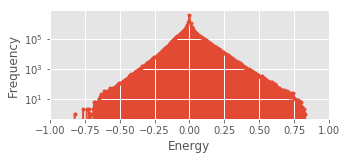

In [22]:
lj_speech = lj_speech_dataset(directory='../data', verbalize=False, resample=None, norm=None, loudness=False,
                              guard=False, lower_hertz=None, upper_hertz=None)
random.shuffle(lj_speech)
plot_histogram(*signal_dataset_histogram(lj_speech[:100]))

Distribution of energy after SoX processing.

100%|██████████| 13100/13100 [00:00<00:00, 18732.94it/s]


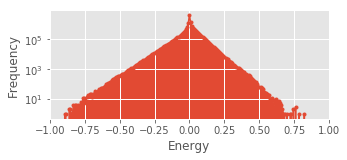

In [23]:
lj_speech_sox = lj_speech_dataset(directory='../data', verbalize=False, resample=24000, norm=None,
                                  loudness=False, guard=True,
                                  lower_hertz=125, upper_hertz=9100)
random.shuffle(lj_speech_sox)
plot_histogram(*signal_dataset_histogram(lj_speech_sox[:100]))

Distribution of energy after a variation of SoX processing.

100%|██████████| 13100/13100 [00:00<00:00, 16950.14it/s]


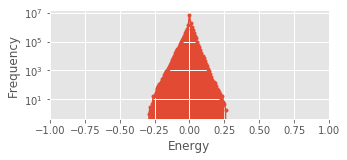

In [31]:
lj_speech_sox = lj_speech_dataset(directory='../data', verbalize=False, resample=24000, loudness=True,
                                  norm=False, guard=True,
                                  lower_hertz=125, upper_hertz=9100)
random.shuffle(lj_speech_sox)
plot_histogram(*signal_dataset_histogram(lj_speech_sox[:100]))

Finally, we take a look at the distribution after mu-law encoding.

100%|██████████| 13100/13100 [00:00<00:00, 18978.24it/s]


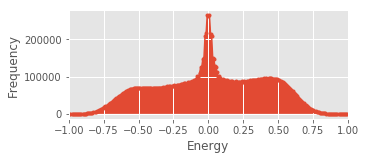

In [28]:
lj_speech_sox = lj_speech_dataset(directory='../data', verbalize=False, resample=24000, norm=False, guard=True,
                                  lower_hertz=125, upper_hertz=9100, loudness=False)
random.shuffle(lj_speech_sox)
get_signal=lambda r: mu_law(librosa.core.load(r['wav'], sr=None)[0])
plot_histogram(*signal_dataset_histogram(lj_speech_sox[:100], get_signal=get_signal, bins=256), log_scale=False)

100%|██████████| 13100/13100 [00:00<00:00, 17606.88it/s]


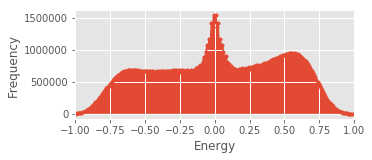

In [26]:
lj_speech_sox = lj_speech_dataset(directory='../data', verbalize=False, resample=24000, norm=True, guard=True,
                                  loudness=True,
                                  lower_hertz=125, upper_hertz=9100)
random.shuffle(lj_speech_sox)
get_signal=lambda r: mu_law(librosa.core.load(r['wav'], sr=None)[0])
plot_histogram(*signal_dataset_histogram(lj_speech_sox[:1000], get_signal=get_signal, bins=256), log_scale=False)

100%|██████████| 13100/13100 [00:00<00:00, 19527.12it/s]


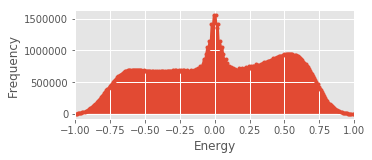

In [27]:
lj_speech_sox = lj_speech_dataset(directory='../data', verbalize=False, resample=24000, norm=True, guard=True,
                                  loudness=False,
                                  lower_hertz=125, upper_hertz=9100)
random.shuffle(lj_speech_sox)
get_signal=lambda r: mu_law(librosa.core.load(r['wav'], sr=None)[0])
plot_histogram(*signal_dataset_histogram(lj_speech_sox[:1000], get_signal=get_signal, bins=256), log_scale=False)

## CMU Arctic Dataset Signal Energy Distribution

First, we look at dataset without preprocessing. Please download this on your own until we add formal dataset support.

In [16]:
import os

original = '/Users/michaelp/Downloads/cmu_us_slt_arctic 2/orig'
processed = '/Users/michaelp/Downloads/cmu_us_slt_arctic/wav'
original = [os.path.join(original, filename) for filename in os.listdir(original) if '.wav' in filename]
processed = [os.path.join(processed, filename) for filename in os.listdir(processed) if '.wav' in filename]

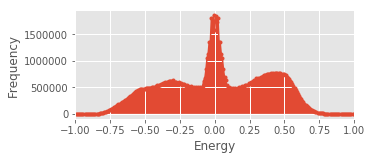

In [17]:
get_signal=lambda wav: mu_law(librosa.core.load(wav, sr=None, mono=False)[0][0])
plot_histogram(*signal_dataset_histogram(original, get_signal=get_signal, bins=256), log_scale=False)

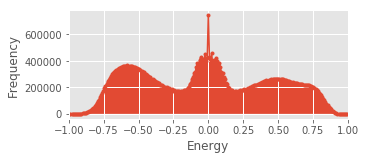

In [18]:
get_signal=lambda wav: mu_law(librosa.core.load(wav, sr=None)[0])
plot_histogram(*signal_dataset_histogram(processed, get_signal=get_signal, bins=256), log_scale=False)

# Mu-Law Signal Energy Distribution

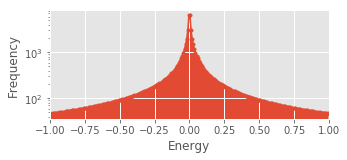

In [19]:
from src.audio import mu_law_encode
from src.audio import mu_law_decode

mu = 255
range_ = (-1.0, 1.0)
samples = np.linspace(0, 255, num=65536)
samples = mu_law_decode(samples)
count, bin_edges = np.histogram(samples, bins=256, range=range_)
bin_centers = center_bins(bin_edges)
plot_histogram(count=count, bin_centers=bin_centers, range_=range_)